In [39]:
import pandas as pd
import numpy as np
import os
import pickle
import sys
import matplotlib.pyplot as plt
import networkx as nx
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import time
from db.database import DatabaseConnector
from dtloader.dataloader import DataLoader
from statsmodels.tsa.stattools import grangercausalitytests
from grangercausality_test import GrangerCausalityTest
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils.utils import *
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.tsatools import lagmat2ds
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from scipy import stats

import warnings
warnings.filterwarnings('ignore')
path = '../stats_files/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Sample log Analysis

mongodb://localhost:27017/
Database connected
Results of Dickey-Fuller Test:
Test Statistic                    0.512262
p-value                           0.985241
#Lags Used                        5.000000
Number of Observations Used    2993.000000
Critical Value (1%)              -3.432537
Critical Value (5%)              -2.862506
Critical Value (10%)             -2.567284
dtype: float64


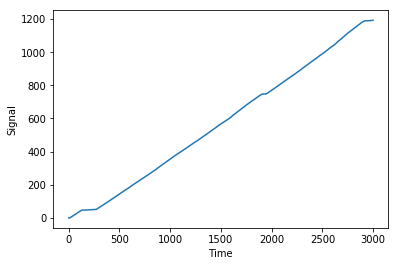

Results of Dickey-Fuller Test:
Test Statistic                -1.256364e+01
p-value                        2.076294e-23
#Lags Used                     4.000000e+00
Number of Observations Used    2.994000e+03
Critical Value (1%)           -3.432536e+00
Critical Value (5%)           -2.862506e+00
Critical Value (10%)          -2.567284e+00
dtype: float64


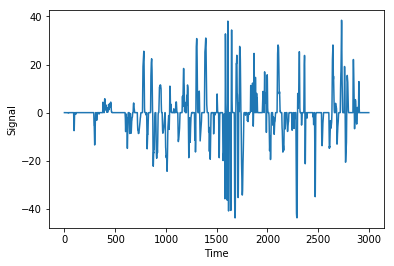

In [2]:
dl = DataLoader()
dl.load('sample.log')
dl.extractinfo(export=False,single_file=True)

#query
currtot = pd.DataFrame(dl.full_dict[('sample.log','CURR')])['CurrTot']
desroll = pd.DataFrame(dl.full_dict[('sample.log','ATT')])['DesRoll']

gc = GrangerCausalityTest()
df1,res1 = gc.stationary_test(currtot,plot=True,print_stats=True)
df2,res2 = gc.stationary_test(desroll,plot=True,print_stats=True)
dl.dbconnector.close_connection()

## Granger Causality Sample Testing

For this test we need to put the two variables in one table with the line indexes and then test everything 

In [3]:
ts = {'ATT':['DesRoll'],'RCIN':['C1']}
dft = corr_var('sample.log',dl,ts,find_corr=False)
dft.dropna(axis=0,how='any',inplace=True) #remove nans

In [4]:
dft.head()

,ATT_DesRoll,RCIN_C1
608,0.0,1491.0
631,0.0,1491.0
639,0.0,1491.0
658,0.0,1491.0
666,0.0,1491.0


# Top 100 Variable Causality Analysis

In [40]:
is_sample = None
vardict = load_top100_dict(sample=is_sample)
top_100_labels = load_top100().name.iloc[:is_sample] #
datalist =os.listdir('../data')
pickle_list =os.listdir('dt_pickles') #files already loaded 

In [41]:
def load_log_info(vardict,file_dict,dl,log_file):
    """
    read information about file and check existing columns from 100 top variables
    load all variables found with their values to dict for direct extraction instead of querying for each
    var from the MongoDB
    """
    print('Loading Log file info')
    for k,v in vardict.items():
        res = dl.dbconnector.query(k+'_'+log_file[:-4]) #find signals in the log files 
        if res != -1: #data exists
                df = pd.DataFrame(res)
                #check for each value if it is stationary or not
                for val in list(set(df.columns).intersection(v)): #loop through the signals
                    if not np.issubdtype(df[val].dtype, np.number):
                            cat_to_int(df,val)
                    try:
                        file_dict[k] = df #editing file_dict
                    except:
                        print('failed')
                    if val != '_id' : #don't include ID columns added by mongoDB
                        coltoceheck.append(k+'_'+val)
    return coltoceheck

def query_var_df(v_signal,file_dict):
        key_comp_v1 = v_signal[:v_signal.index('_')]
        var_sub_v1 = v_signal[v_signal.index('_')+1:]
        sr1 = file_dict[key_comp_v1][var_sub_v1]
        lineindex1 = file_dict[key_comp_v1]['lineIndex']
        df1= pd.DataFrame({key_comp_v1 + '_' + var_sub_v1:sr1,'lineIndex':lineindex1}).set_index('lineIndex')
        return key_comp_v1 , var_sub_v1 , df1
    
def load_from_pickle(log,df_dict,empty_dict_labels):
    print('Loading {} from pickle...'.format(log))
    loaded_d = load_pickle('dt_pickles',log[:-4]+'.pickle')
    for lk,lval in loaded_d.items():
            encode_cause(df_dict,lk,loaded_d,empty_dict_labels)

In [42]:
df_dict = {} # this dict should contain all info required to aggregate
empty_dict_labels = {}
#init empty dict with signals as columns
for l in top_100_labels:
    empty_dict_labels[l] = np.nan #empty labels to add to the signal dataframe when using pd.concat
#init dataframes
for l in top_100_labels: #every signal has a dataframe of 100 columns to edit
    df_dict[l] = pd.DataFrame(empty_dict_labels,index=[0])

In [43]:
dl = DataLoader()
gc_t = GrangerCausalityTest()
time_list = []

#load pickle to check already loaded files 
#for error mitegation
for i,log in enumerate(datalist): #loop through the files    
    if not log == '58c3e69a03d9b00f21696b11.log':
        print(i)
        continue
        
#     if i == 50:
#         break
    #init variables
    doubles_track = []
    file_dict = {}
    coltoceheck = []
    dictc = {}
    for sig in top_100_labels:#init dictc with all required columns/signals
        dictc[sig] = []
        
        
    #checking if this log was loaded already
    if log[:-4]+'.pickle' in pickle_list:
        print('loading and skipping log: ', log)
        load_from_pickle(log,df_dict,empty_dict_labels)
        continue
    
    print('File:{} --  {} / {}'.format(log,i,len(datalist)-1))
    
    # only loop through columns that exist without checking and try to query more columns performance wise much better
    start_time = time.time()
    
    coltoceheck = load_log_info(vardict,file_dict,dl,log)
    
    #columns to check
    #check the causation between the columns
    size_col = len(coltoceheck)
    print('Number of Signals to check :', size_col)
    for vnum,v1 in enumerate(coltoceheck):
        key_comp_v1,var_sub_v1,df1 = query_var_df(v1,file_dict)
        if not check_state(gc_t,df1[key_comp_v1 + '_' + var_sub_v1]):
            continue
        #------------------------------------------
        for v2 in coltoceheck:
            if v1 == v2 :
                continue
            key_comp_v2,var_sub_v2,df2 = query_var_df(v2,file_dict)

            if not check_state(gc_t,df2[key_comp_v2 + '_' + var_sub_v2]):
                continue
            #------------------------------------------
            
            #we want to set the line index between two variables
            full_df = pd.concat([df1,df2],axis =1).fillna(method = 'ffill')  
            full_df.dropna(axis=0,how='any',inplace=True) #remove nans
            #--------------------------------------------------------------------          
            gc = GrangerCausalityTest(pd_frame=full_df,maxlag=3)
            try:
                gc_resp = gc.var_grangertest(check_stationary=False,verbose=False,use_simpleols=False)
            except: #can be due to max lags
                #ignore this v2
                continue
            if not np.isnan(gc_resp):
                #this must be saved
                #print(gc.dict_res)
                #saving results to a dictc per variable
                v1_v2 = gc.dict_res[v1 + ' causes ' +v2]
                v2_v1 = gc.dict_res[v2 + ' causes ' +v1]                            
                if v1_v2 and v2_v1:
                    dictc[v1].append(v2+'bc')
                    dictc[v2].append(v1+'bc')
                elif v1_v2:
                    dictc[v1].append(v2)
                elif v2_v1:
                    dictc[v2].append(v1)
                elif gc.dict_res['no-causal']:
                    dictc[v1].append(v2+'nc')
                    dictc[v2].append(v1+'nc')
        
        encode_cause(df_dict,v1,dictc,empty_dict_labels) #editing the global dict with dataframe of components as values
    save_as_pickle(dictc, 'dt_pickles',log[:-4]+'.pickle')
    time_list.append((log,os.path.getsize('../data/'+log)/1000000,time.time() - start_time))
    break

mongodb://localhost:27017/
Database connected
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265


In [33]:
time_df(time_list,plot=False,save_path=path+'causality_time_statistics.csv')

In [34]:
total_df = pd.DataFrame(empty_dict_labels,index=['empty'])
for ky,val in df_dict.items():
    total_df.loc[ky,:] = val.agg("mean", axis=0)
total_df.drop('empty',inplace=True)
thresh_values = True
if thresh_values:
    for c in total_df.columns:
        nc_idx = total_df[c] <= 0.5
        both_idx = (total_df[c] >= 1.5) 
        cause_idx = (total_df[c] >= 0.5) & (total_df[c] <= 1.5)
        causes_labels = pd.Series(total_df.index[cause_idx])
        total_df.loc[ nc_idx , c] = 0
        total_df.loc[ cause_idx , c] =1
        total_df.loc[ both_idx , c] =2
total_df.to_csv(path+'full_causality_table.csv')

In [35]:
total_df_labeled = total_df.copy()
for c in total_df.columns:
    nc_idx = total_df[c] <= 0.5
    both_idx = (total_df[c] >= 1.5) 
    cause_idx = (total_df[c] >= 0.5) & (total_df[c] <= 1.5)
    causes_labels = pd.Series(total_df.index[cause_idx])
    total_df_labeled.loc[ nc_idx , c] = 'no-causal'
    total_df_labeled.loc[ cause_idx , c] = list(causes_labels.astype(str)  +  ' causes ' + c)
    total_df_labeled.loc[ both_idx , c] = 'both'
total_df_labeled.to_csv(path+'full_causality_table_labeled.csv')

# Network Analysis and EDA

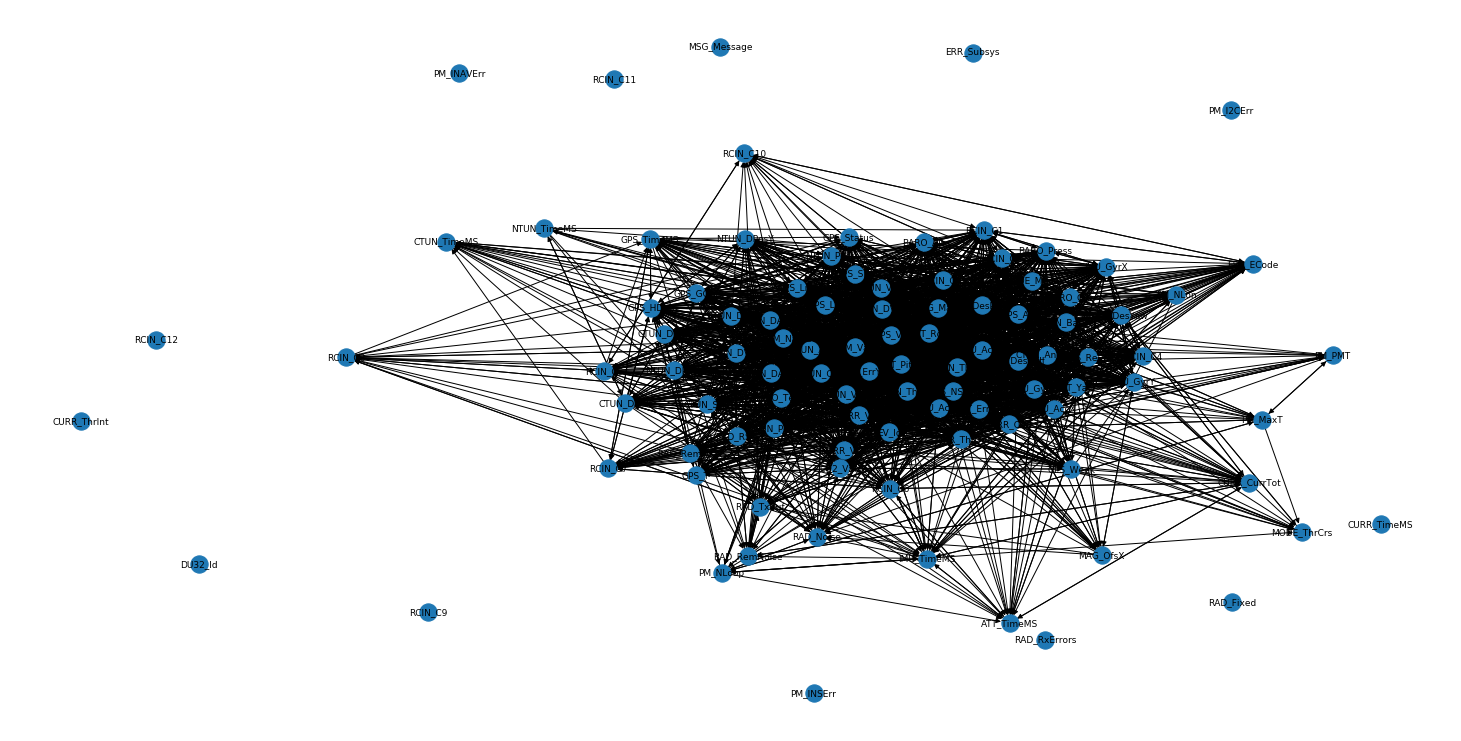

In [37]:
df = total_df.copy()
DG = nx.DiGraph()
DG.add_nodes_from(df.columns)
for idx in df.index:
    ltuples = [(idx,cl) for cl in df.columns[df.loc[idx] == 1] if cl != idx]
    ltuples_bi = [(idx,cl) for cl in df.columns[df.loc[idx] == 2 ] if cl != idx] + [(cl,idx) for cl in df.columns[df.loc[idx] == 2 ] if cl != idx]
    DG.add_edges_from(ltuples)
    DG.add_edges_from(ltuples_bi)
#create tuples
pos = nx.spring_layout(DG,k=1,iterations=50)
plt.figure(figsize=(20,10))
nx.draw(DG,with_labels=True,font_size=9,pos=pos)
plt.draw()
plt.show()

In [ ]:
#graph causality

# Top 100 Variable Stationary Analysis

In [ ]:
df_100 = load_top100()
vardict = load_top100_dict()
datalist =os.listdir('../data')

In [ ]:
df_100['count_stat'] = np.zeros(len(df_100))
gc = GrangerCausalityTest()
res_bool= None
for i,log in enumerate(datalist): #loop through the files
    print('File:{} --  {} / {}'.format(log,i,len(datalist)-1))
    for key,values in vardict.items(): #loop through components 
        print('Loading Key : ', key)
        res = dl.dbconnector.query(key+'_'+log[:-4]) #find signals in the log files 
        if res != -1: #data exists
                df = pd.DataFrame(res)
                #check for each value if it is stationary or not
                for val in list(set(df.columns).intersection(values)): #loop through the signals
                    if not np.issubdtype(df[val].dtype, np.number):
                            cat_to_int(df,val)
                    try:
                        _,res_bool = gc.stationary_test(df[val],plot=False,print_stats=False)
                    except Exception as err:
                        print('Stationary test failed',err)
                    if res_bool:    
                        df_100.loc[df_100.name == key+'_'+val,'count_stat'] +=1

In [ ]:
df_100['exist_percent'] = (df_100['count_stat'] / df_100['count'])

In [ ]:
dt = df_100.sort_values('exist_percent',ascending=False)
dt.to_csv(path+'stationary_percent.csv')

In [ ]:
plt.figure(figsize=(20,15))
num_var = 100
g = sns.barplot(x='name',y='exist_percent',data=dt.iloc[:num_var,:])
g.set_xticklabels(labels=dt.iloc[:num_var,0],rotation=90)
plt.show()